<a href="https://colab.research.google.com/github/HRI328/AXA-CASE-1/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [305]:
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import math

from zipfile import ZipFile
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer



# **Prepare Data**


### Unzip Uploaded File
Transcript_v3.zip file is ready uploaded manually to Google Colab

In [286]:
file_format = "zip"
file_name = "transcripts_v3"

file_full_name = file_name + "." + "zip"
print(file_full_name)

with ZipFile(file_full_name, 'r') as zip:
    zip.printdir()
    print('Extracting all the files now...')
    for file in zip.namelist():
      zip.extractall()
    print('Done')

transcripts_v3.zip
File Name                                             Modified             Size
manifest.mf                                    2024-10-11 07:08:44          101
transcripts_v3/                                2024-10-11 07:08:44           98
transcripts_v3/transcript_0.txt                2024-10-11 07:08:44         2298
transcripts_v3/transcript_1.txt                2024-10-11 07:08:44         1915
transcripts_v3/transcript_2.txt                2024-10-11 07:08:44         2021
transcripts_v3/transcript_3.txt                2024-10-11 07:08:44         2572
transcripts_v3/transcript_4.txt                2024-10-11 07:08:44         1537
transcripts_v3/transcript_5.txt                2024-10-11 07:08:44         2425
transcripts_v3/transcript_6.txt                2024-10-11 07:08:44         2209
transcripts_v3/transcript_7.txt                2024-10-11 07:08:44         2062
transcripts_v3/transcript_8.txt                2024-10-11 07:08:44         2670
transcripts_v3/transc

### Input Data to Google Colab and Overview

The transcripts_v3.zip data file has been unzipped into transcripts_v3 folder. Here the unzipped text data is inputted into Googl Colab to have a look.
The result shows this data file has total 200 documents without label. The diolage between member and agent is sparated by "\n"**bold text**.

In [291]:
text_all = []
for i in range(200):

  # Keep in mind to change the following according to above unzip file path
  unzipped_file_name = "transcripts_v3/transcript_" + str(i) + ".txt"

  # read all files in unzipped folder and attached to list
  file = open(unzipped_file_name, "r")
  test_1 = file.read()
  text_all.append(test_1)
  file.close

n_documents = len(text_all)
print(f"Number of documents is : {n_documents}\n")

print(f"Print any one of the text message to see the structure \n")
text_all[4]


Number of documents is : 200

Print any one of the text message to see the structure 



"Member: Hi, I'd like to schedule an appointment with a specialist. My member ID is MEM123456.\n\nCustomer Support: Thank you for calling us, MEM123456. Can you please tell me what type of specialist you're looking for and what date and time you'd prefer for the appointment?\n\nMember: I'm looking for a dermatologist and I was thinking maybe next Wednesday or Thursday. Do you have any availability?\n\nCustomer Support: Let me check our schedule. (pause) Okay, I've checked and we have a few options available for next Wednesday and Thursday. We have Dr. Smith available on Wednesday at 2 PM and Dr. Johnson available on Thursday at 10 AM. Both are highly rated specialists in dermatology. Which one would you prefer?\n\nMember: That sounds great. Can you tell me a bit more about Dr. Smith and Dr. Johnson? What are their specialties within dermatology?\n\nCustomer Support: Dr. Smith specializes in skin cancer treatment and cosmetic dermatology, while Dr. Johnson focuses on acne treatment and 

### Extract Customer Information

The purpose of this analysis is to identify if the issue of customer is sorted out or needs to follow up action. This means the result is decided by customer. Therefore here only customer, i.e., member's talk is extracted only using the information from above message reading.

In [292]:
# Extract customer side information
customer_list0 = []
for i in range(n_documents):
  customer_1 = list(filter(lambda x: 'member' in x.lower(), text_all[i].split('\n')))
  customer_list0.append(' '.join(customer_1))

# Remove string "Member:"
customer_list = []
for i in range(n_documents):
  customer_list.append(customer_list0[i].replace('Member:', ''))

print(f"Number of customer message is : {len(customer_list)}\n\n")

print(f"Print any one of the customer message to see the structure:")
print("customer_list should have the talking from member only.\n\n")
customer_list[20]

Number of customer message is : 200


Print any one of the customer message to see the structure:
customer_list should have the talking from member only.




' Hi, I\'m having trouble logging in to my online service account. I\'m trying to register but it\'s not letting me. My member ID is MEM456278.  It just says "Invalid username or password" but I\'m pretty sure I\'m entering the correct information.  Yeah, that would be great. I\'ve tried resetting it before, but maybe I did something wrong. Technical Support: Sure thing. To reset your password, go to the login page and click on "Forgot Password." Enter your member ID, which is MEM456278, and follow the prompts to create a new password. Make sure to use a strong password that includes uppercase and lowercase letters, numbers, and special characters.  Okay, I\'ve done that. But now it\'s saying my account is locked.  Yeah, my date of birth is March 12, 1990, and the last four digits of my payment method are 1234.  Awesome, thank you so much! I\'m able to log in now.  No, that\'s all. Thanks again for your help.'

### Standardize Text Message
Convert all character into lower case and replace all special characters by space, replace multiple space by single space.

In [293]:
def standard_text(inputText):
  # This function is used to standardize the text massage
  # inputText : test string
  # return : tensor
  inputText_low = tf.strings.lower(inputText)
  inputText_low1 = tf.strings.regex_replace(inputText_low, '[^a-z0-9 ]', ' ')
  inputText_low2 = tf.strings.regex_replace(inputText_low1, ' +', ' ')
  return tf.strings.regex_replace(inputText_low2, '[%s]' % re.escape(string.punctuation), '')

In [294]:
# Test the standardize text function
standard_text(customer_list[2])

<tf.Tensor: shape=(), dtype=string, numpy=b' hi i m calling about my recent doctor s visit i was charged a copay of 50 but i thought my policy covered that service with a 20 copay customer support i apologize for the inconvenience mr johnson can you please provide me with your member id so i can look into this further it s mem456789 it was on february 10th and it was a routine physical exam yeah because my policy says that routine physical exams have a 20 copay or sometimes no copay at all okay that sounds good how long will it take to resolve this alright that sounds good can i get a reference number for the case okay got it thank you for your help alright thanks no that s all you too thanks '>

### Check Number of Unique Words in all customer talking

In [295]:
# convert tensor into list
word_list = [standard_text(item).numpy().decode('utf-8') for item in customer_list]

# Calculate the number of unique words
unique_words_num = len(set(''.join(word_list).split(" ")))
print(f"Number of unique words in all customer talking is : {unique_words_num}")

# Calculate the length of each documents
sentencs_len = []
for strValue in word_list:
  sentencs_len.append(len(strValue.split(" ")))

# number of words in the longest document
word_num_longest_sentencs = max(sentencs_len)
print(f"Number of words in the longest sentence is : {word_num_longest_sentencs}")


Number of unique words in all customer talking is : 1022
Number of words in the longest sentence is : 235


### Mapping Text Features to Integer Sequences

In [296]:
# maximum number of words set
max_features = unique_words_num
# text sentence could include maximum word
sequence_length = word_num_longest_sentencs

# Vectorization of text message
vectorize_layer = layers.TextVectorization(
    standardize=standard_text,
    max_tokens=max_features,
    pad_to_max_tokens=True,
    ngrams=1,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(customer_list)

In [297]:
# Make text vectorization
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text)

In [298]:
# Random vocabulary check
print("0 to 9 ----->", vectorize_layer.get_vocabulary()[:10])
print("20 to 29 ----->", vectorize_layer.get_vocabulary()[20:30])
print("300 to 309 ----->", vectorize_layer.get_vocabulary()[300:310])
print("1000 to 1009 ----->", vectorize_layer.get_vocabulary()[1000:1010])
print("Vaocabulary size : {}".format(len(vectorize_layer.get_vocabulary())))

0 to 9 -----> ['', '[UNK]', 'i', 'my', 'you', 'that', 'to', 'is', 'the', 's']
20 to 29 -----> ['can', 'member', 'was', 'id', 'in', 'no', 'hi', 'policy', 'sounds', 'all']
300 to 309 -----> ['we', 'update', 'told', 'them', 'ridiculous', 'reprocess', 'plan', 'orthopedic', 'multiple', 'mr']
1000 to 1009 -----> ['8', '76700', '73600', '715', '654321', '6', '5555', '500', '5', '4219']
Vaocabulary size : 1022


### Embedding
Reduce high dimension to low dimension

In [299]:
embedding = Embedding(input_dim=max_features, output_dim=16)

customer_list_embedding = embedding(vectorize_layer(customer_list))

In [300]:
# check the shape of the embedding
customer_list_embedding.shape

TensorShape([200, 235, 16])

In [301]:
# Check embedding
customer_list_embedding[0, 0]

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 0.04094848,  0.01001061,  0.02333758, -0.03586971, -0.0082862 ,
        0.01364901,  0.01496837, -0.01733262, -0.04305521,  0.02340988,
        0.0088978 ,  0.01604669,  0.01433304, -0.01794728,  0.03478947,
       -0.04186342], dtype=float32)>

In [302]:
# Reshape the data to 2D by averaging the embedding for each document for k-mean
customer_list_embedding_2d = tf.reduce_mean(customer_list_embedding, axis=1).numpy()
customer_list_embedding_2d.shape

(200, 16)

# Modelling

## Using K-mean to Clusterring
The text message has not been labelled. So unsupervised machine learning is used. Here k-mean is used.
The reason is:
     
*   Simple: easy to understand and implement.
*   Efficient: fast compared to other clustering algorithms.
*   Interpretable: easy to understand and can help derive insights.

Here the number of clusters is decided by the elbow method although these talking is the diolage between member and agent in medical insurance. Topic is about the issue from member and the result has only two. One is sorted and another one is to need the follow up call. Anyway some sorted issue might still need some follow up action.


### Decide Number of Cluster
From the elbow graph, It is the best to set the cluster number as 4.

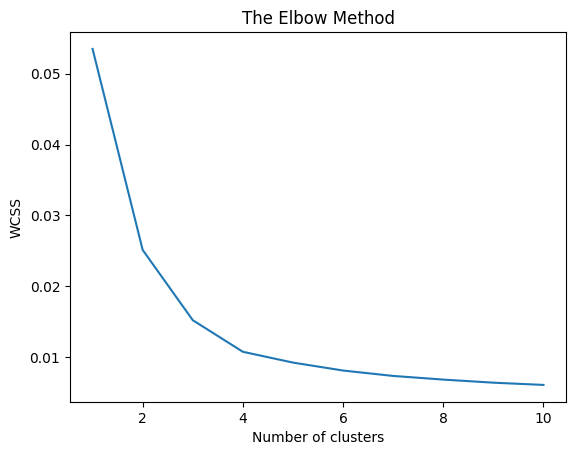

In [303]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(customer_list_embedding_2d)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Set cluster number as 4 to build the model

In [304]:
# set number of clusters as 3 to build the model
kmeans = KMeans(n_clusters=4,
                tol=.0001,
                max_iter=15,
                random_state=0)
label = kmeans.fit_predict(customer_list_embedding_2d)


### Model Performance Check
silhouette_score is a metric to calculate the goodness_of_fitness of a clustering algorithm, which ranges from -1 to 1. 0 means clusters are overlapping and either data or the number of cluster are incorrect. 1 means cluster is ver dense and nicely separated. Negative value means element is possibly assigned to the wrong class.
Here the silhouette_score is 0.327. It is acceptable.

In [308]:
# Check the model performance built by k-mean
silhouette_score(customer_list_embedding_2d, label)

# The following methods could be used to check model performance as well
# calinski_harabasz_score(customer_list_embedding_2d, label)
# davies_bouldin_score(customer_list_embedding_2d, label)

0.3602372

### Attach Cluster Label to Data

In [309]:
# Convert Text Message into Dataframe and Attaching Label Identified
customer_text_df = pd.DataFrame(customer_list, columns=['text'])
customer_text_df['label'] = label

### Read some text message to identify the physical meaning of the label

In [310]:
# Display text message with label to select the text message to read to define label meaning
# customer_text_df.loc[50:70]

# The following text have been read and given the label the physical meaning
# text_all[5]    # 0 -> find reason need investigation to decide
# text_all[8]    # 0 -> find reason need investigation to decide
# text_all[66]   # 0 -> find reason need investigation to decide
# text_all[1]    # 1 -> resolved after investigation
# text_all[16]   # 1 -> resolved after investigation
# text_all[52]   # 1 -> resolved after investigation
# text_all[3]    # 2 -> not resolved to follow up action to investigation
# text_all[42]   # 2 -> not resolved to follow up action to investigation
# text_all[56]   # 2 -> not resolved to follow up action to investigation
# text_all[4]    # 3 -> resolved
# text_all[12]   # 3 -> resolved
# text_all[50]   # 3 -> resolved

In [311]:
# Attach label physical meaning to dataframe and display top 5 text message
label_dic = {0 : "Follow up", 1: "Resolved", 2: "Follow up", 3: "Resolved"}
customer_text_df['labelMeaning'] = customer_text_df['label'].map(label_dic)
customer_text_df.head()

,text,label,labelMeaning
0,"Hi, I'm calling to get a case pre-authorized....",3,Resolved
1,"Hi, I'm calling about a denied claim I receiv...",1,Resolved
2,"Hi, I'm calling about my recent doctor's visi...",3,Resolved
3,"Hi, I'm calling about my recent visit to the ...",2,Follow up
4,"Hi, I'd like to schedule an appointment with ...",3,Resolved


### Bar Chart Shows Number of Sorted and Fellow up Action

The bar chart shows that of 200 customer calls, over 60 calls need the following up action.

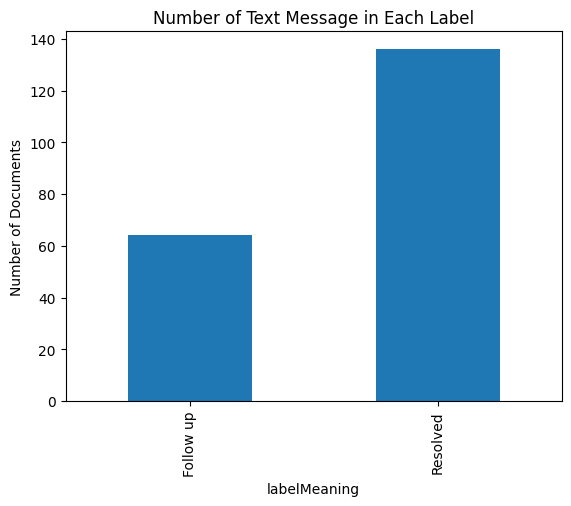

In [312]:
# Group by label meaning to count
count_by_label_df = customer_text_df.groupby('labelMeaning').size()

# Rename the series to 'count' to provide a column name for the plot.
count_by_label_df = count_by_label_df.rename('count')

# plot the dataframe
count_by_label_df.plot(x='labelMeaning', y='count', kind='bar', title='Number of Text Message in Each Label')
plt.ylabel('Number of Documents')
plt.show()

# Get Data Insight

Scatter Plot from first three features in the Average Embedding for the vasiulazation check of the cluster label

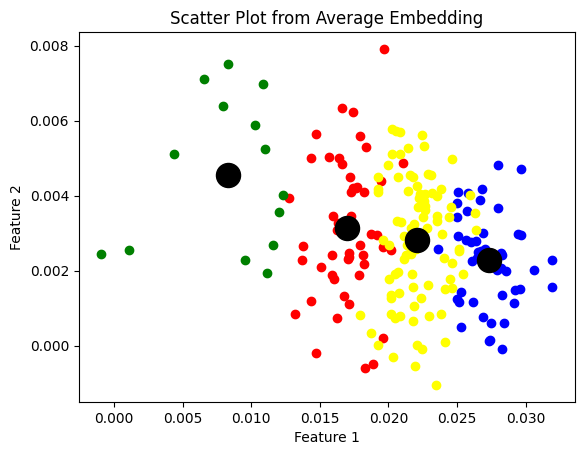

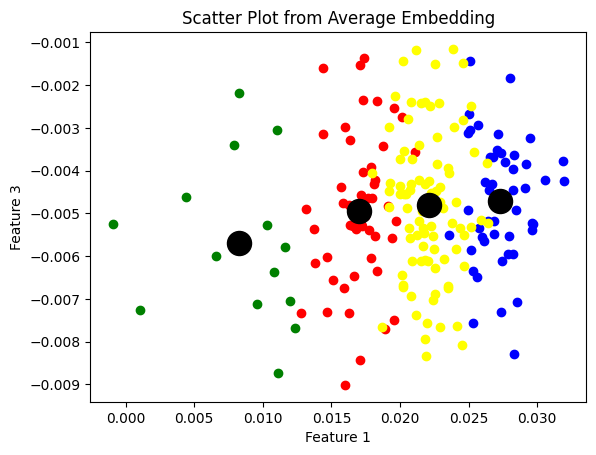

In [315]:
# Extracting average embedding information for each cluster label
class0 = customer_list_embedding_2d[label == 0]
class1 = customer_list_embedding_2d[label == 1]
class2 = customer_list_embedding_2d[label == 2]
class3 = customer_list_embedding_2d[label == 3]

# Scatter plot using first two features
plt.scatter(class0[:, 0], class0[:, 1], c='red', label='Cluster 0')
plt.scatter(class1[:, 0], class1[:, 1], c='blue', label='Cluster 1')
plt.scatter(class2[:, 0], class2[:, 1], c='green', label='Cluster 2')
plt.scatter(class3[:, 0], class3[:, 1], c='yellow', label='Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='black', label='Centroids')
plt.title('Scatter Plot from Average Embedding')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Scatter plot using first and third features
plt.scatter(class0[:, 0], class0[:, 2], c='red', label='Cluster 0')
plt.scatter(class1[:, 0], class1[:, 2], c='blue', label='Cluster 1')
plt.scatter(class2[:, 0], class2[:, 2], c='green', label='Cluster 2')
plt.scatter(class3[:, 0], class3[:, 2], c='yellow', label='Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s=300, c='black', label='Centroids')
plt.title('Scatter Plot from Average Embedding')
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.show()

### Get Insight

1.   Find the document nearest to the centroid using the centroid of k-mean model to see the message information
2.   Extract the key words from the document nearest to the centroid



In [316]:
# Find the document nearest to centroid and print out


dist0 = []
dist1 = []
dist2 = []
dist3 = []

for i in range(200):
  # Find the distance between average embedding and centroid
  dist0_0 = math.dist(customer_list_embedding_2d[i], kmeans.cluster_centers_[0])
  dist1_0 = math.dist(customer_list_embedding_2d[i], kmeans.cluster_centers_[1])
  dist2_0 = math.dist(customer_list_embedding_2d[i], kmeans.cluster_centers_[2])
  dist3_0 = math.dist(customer_list_embedding_2d[i], kmeans.cluster_centers_[3])

  dist0.append(dist0_0)
  dist1.append(dist1_0)
  dist2.append(dist2_0)
  dist3.append(dist3_0)

# Find the index that embedding nearest to the centroid
label0_near_centroid = dist0.index(min(dist0))
label1_near_centroid = dist1.index(min(dist1))
label2_near_centroid = dist2.index(min(dist2))
label3_near_centroid = dist3.index(min(dist3))

print("==========================================================")
print("Typical customer talking to agent for label 0 \n")
print(customer_list[label0_near_centroid])
print("==========================================================\n\n")

print("==========================================================")
print("Typical customer talking to agent for label 1 \n")
print(customer_list[label1_near_centroid])
print("==========================================================\n\n")

print("==========================================================")
print("Typical customer talking to agent for label 2 \n")
print(customer_list[label2_near_centroid])
print("==========================================================\n\n")

print("==========================================================")
print("Typical customer talking to agent for label 3 \n")
print(customer_list[label3_near_centroid])
print("==========================================================")

Typical customer talking to agent for label 0 

 Hi, I'm calling about my recent visit to the doctor's office. I was charged a copay of $50 for a service, but I'm pretty sure my policy doesn't require a copay for that service. Customer Support: I apologize for the inconvenience, can you please provide me with your member ID so I can look into this further?  It's MEM123456.  My name is Emily Wilson and my date of birth is March 12, 1985.  It was on February 20th and I had a follow-up appointment with my primary care physician.  Okay, sure.  That's what I thought. So, what's going to happen next?  Okay, that sounds great. How long will it take for the refund to be processed?  Alright, thank you for your help in resolving this issue.  No, that's all. Thank you again.  Great, thank you. I appreciate it.  Thank you. Bye.


Typical customer talking to agent for label 1 

 Hi, I'm calling to request a pre-authorization for a medical procedure. My name is Emily Wilson and my member ID is MEM12

### Extract Key Words

It is extracted that the key words in the documents of four different groups that is the nearest the centroid to understand the characters of each cluster labels.

From the key words in each cluster label, we could see the label 1 and 3 are mainly related to the authorization, label 0 is related to copay and refund, label 2 is related to online member account.




In [317]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
kw_model = KeyBERT(model=model)

In [320]:
# Key words from the label 0
print("Key Words in Cluster Label 0")
kw_model.extract_keywords(customer_list[label0_near_centroid], keyphrase_ngram_range=(1, 1), stop_words=None, top_n=10)

Key Words in Cluster Label 0


[('refund', 0.4739),
 ('copay', 0.4406),
 ('appointment', 0.3208),
 ('physician', 0.2679),
 ('customer', 0.2666),
 ('service', 0.258),
 ('doctor', 0.2525),
 ('care', 0.2365),
 ('mem123456', 0.2331),
 ('resolving', 0.206)]

In [321]:
# Key words from label 1
print("Key Words in Cluster Label 1")
kw_model.extract_keywords(customer_list[label1_near_centroid], keyphrase_ngram_range=(1, 1), stop_words=None, top_n=10)

Key Words in Cluster Label 1


[('authorization', 0.4456),
 ('knee', 0.346),
 ('procedure', 0.3061),
 ('pre', 0.2967),
 ('hospital', 0.2829),
 ('arthritis', 0.2753),
 ('surgery', 0.2608),
 ('medical', 0.2538),
 ('done', 0.2375),
 ('doctor', 0.237)]

In [322]:
# Key words from label 3
print("Key Words in Cluster Label 2")
kw_model.extract_keywords(customer_list[label2_near_centroid], keyphrase_ngram_range=(1, 1), stop_words=None, top_n=10)

Key Words in Cluster Label 2


[('registering', 0.5395),
 ('register', 0.4929),
 ('mem123456', 0.4555),
 ('member', 0.3951),
 ('account', 0.3901),
 ('invalid', 0.3504),
 ('id', 0.3438),
 ('password', 0.3295),
 ('entered', 0.3029),
 ('online', 0.2865)]

In [323]:
# Key words from label 3
print("Key Words in Cluster Label 3")
kw_model.extract_keywords(customer_list[label3_near_centroid], keyphrase_ngram_range=(1, 1), stop_words=None, top_n=10)

Key Words in Cluster Label 3


[('deductible', 0.3304),
 ('authorization', 0.3047),
 ('procedure', 0.3026),
 ('pre', 0.2919),
 ('mem123456', 0.2306),
 ('doctor', 0.2154),
 ('1234', 0.2093),
 ('555', 0.1955),
 ('contact', 0.193),
 ('dr', 0.1872)]